# ZNE with PT

# Test Trotterization on FakeJakarta with QREM and ZNE

- Status: Incomplete

# Import Libiraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from pprint import pprint
# plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts
import pickle
import time
import datetime

In [2]:
# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile, Aer
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
from qiskit.transpiler.passes import RemoveBarriers

In [3]:
# Import QREM package
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.ignis.mitigation import expectation_value

/var/folders/vr/d82vcp297v78vk4sb0_nzzdc0000gn/T/ipykernel_38250/3056705909.py:2: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter


In [4]:
# Import mitiq for zne
import mitiq

In [5]:
# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits
from qiskit.quantum_info import state_fidelity

# Import Libraries

In [6]:
import sys
import importlib
sys.path.append("./")
import circuit_utils, zne_utils, tomography_utils, sgs_algorithm
importlib.reload(circuit_utils)
importlib.reload(zne_utils)
importlib.reload(tomography_utils)
importlib.reload(sgs_algorithm)
from circuit_utils import *
from zne_utils import *
from tomography_utils import *
from sgs_algorithm import *

# Set Parameters

In [7]:
# Combine subcircuits into a single multiqubit gate representing a single trotter step
num_qubits = 3

# The final time of the state evolution
target_time = np.pi

# Parameterize variable t to be evaluated at t=pi later
dt = Parameter('t')

# Convert custom quantum circuit into a gate
trot_gate = trotter_gate(dt)

# initial layout
initial_layout = [5,3,1]

# Prepare Circuits

logical circuits = little endian
name: lq = logical qubits 

In [8]:
# Number of trotter steps
num_steps = 100

print("trotter step: ", num_steps)
# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(num_qubits, name="q")
qc = QuantumCircuit(qr)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
make_initial_state(qc, "110")  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

subspace_encoder_init110(qc, targets=[0, 1, 2]) # encode
trotterize(qc, trot_gate, num_steps, targets=[1, 2]) # Simulate time evolution under H_heis3 Hamiltonian
subspace_decoder(qc, targets=[0,1,2]) # decode

trotter step:  100


In [9]:
# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
t1 = time.perf_counter()
qc = qc.bind_parameters({dt: target_time / num_steps})
t2 = time.perf_counter()
print("created qc,", t2 - t1, "s")

# Generate state tomography circuits to evaluate fidelity of simulation
t1 = time.perf_counter()
st_qcs = state_tomography_circuits(qc, [0, 1, 2][::-1])  #! state tomography requires === BIG ENDIAN === 
t2 = time.perf_counter()
print("created st_qcs (length:", len(st_qcs), "),", t2 - t1, "s")

# remove barriers
t1 = time.perf_counter()
st_qcs = [RemoveBarriers()(qc) for qc in st_qcs]
t2 = time.perf_counter()
print("removed barriers from st_qcs,", t2 - t1, "s")

# optimize circuit
t1 = time.perf_counter()
t3_st_qcs = transpile(st_qcs, optimization_level=3, basis_gates=["sx", "cx", "rz"])
t2 = time.perf_counter()
print("created t3_st_qcs (length:", len(t3_st_qcs), "),", t2 - t1, "s")

created qc, 0.04207941900000023 s
created st_qcs (length: 27 ), 0.03407034700000011 s
removed barriers from st_qcs, 2.5394904700000005 s
created t3_st_qcs (length: 27 ), 21.241341043000006 s


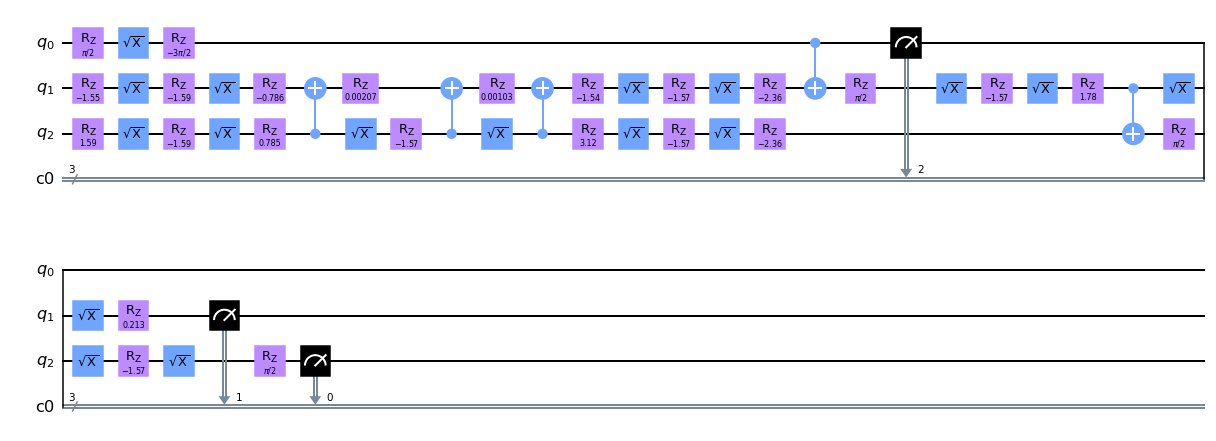

In [10]:
t3_st_qcs[0].draw("mpl")

In [11]:
# zne wrapping
t1 = time.perf_counter()
zne_qcs = zne_wrapper(t3_st_qcs)
t2 = time.perf_counter()
print("created zne_qcs (length:", len(zne_qcs), "),", t2 - t1, "s")

t1 = time.perf_counter()
zne_qcs = transpile(zne_qcs, optimization_level=0, basis_gates=["sx", "cx", "rz"])
t2 = time.perf_counter()
print("decomposed zne_qcs into basis gates (length:", len(zne_qcs), "),", t2 - t1, "s")

t1 = time.perf_counter()
t3_zne_qcs = transpile(zne_qcs, optimization_level=3, basis_gates=["sx", "cx", "rz"])
t2 = time.perf_counter()
print("optimized zne_qcs -> create t3_zne_qcs (length:", len(t3_zne_qcs), "),", t2 - t1, "s")

t1 = time.perf_counter()
t3_zne_qcs = transpile(t3_zne_qcs, optimization_level=0, basis_gates=["sx", "cx", "rz"], initial_layout=initial_layout)
t2 = time.perf_counter()
print("fit the t3_zne_qcs to the initial layoit (length:", len(t3_zne_qcs), "),", t2 - t1, "s")

created zne_qcs (length: 81 ), 16.405132784000003 s
decomposed zne_qcs into basis gates (length: 81 ), 1.9144548459999982 s
optimized zne_qcs -> create t3_zne_qcs (length: 81 ), 11.496133398999994 s
fit the t3_zne_qcs to the initial layoit (length: 81 ), 0.5900471789999955 s


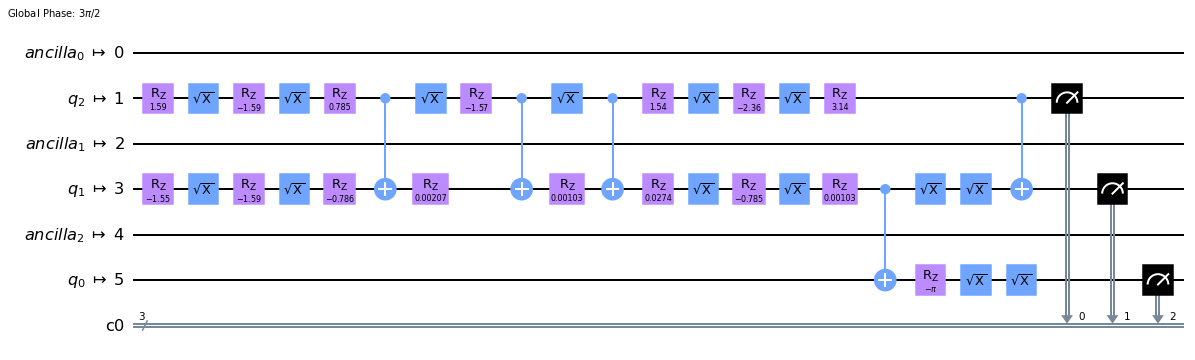

In [12]:
t3_zne_qcs[-3].draw("mpl")

# Set Backend

In [13]:
from qiskit.test.mock import FakeJakarta
# backend = FakeJakarta()
# backend = Aer.get_backend("qasm_simulator")

IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
print("provider:", provider)
backend = provider.get_backend("ibmq_jakarta")

provider: <AccountProvider for IBMQ(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')>


# Execute QREM Circuits

In [14]:
# QREM
shots = 1 << 13
qr = QuantumRegister(num_qubits)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
cal_job = execute(meas_calibs, backend=backend, shots=shots, optimization_level=3, initial_layout = initial_layout)
print('Job ID', cal_job.job_id())

Job ID 6255a7a47ec04e3191b05eda


# Execute Circuits

In [15]:
shots = 1 << 13
reps = 8 # unused
jobs = []
for _ in range(reps):
    job = execute(t3_zne_qcs, backend, shots=shots, optimization_level = 0) # 毎回チェック: ここちゃんと変えた？
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID 6255a7a78233e8e33dad1bcb
Job ID 6255a7a9a21878642f6482db
Job ID 6255a7aba2187841ec6482dc
Job ID 6255a7aebca2b992c777be51
Job ID 6255a7b0d8e31ae0fc8b4dea
Job ID 6255a7b3d66fd6402aa9493f
Job ID 6255a7b5d66fd65f26a94940
Job ID 6255a7b83bfc76f2b3eac4ff


In [16]:
dt_now = datetime.datetime.now()
print(dt_now)

2022-04-13 01:24:25.403860


In [17]:
import pickle
with open("jobs_jakarta_100step_" + dt_now.strftime('%Y%m%d_%H%M%S') + "_.pkl", "wb") as f:
    pickle.dump({"jobs": jobs, "cal_job": cal_job}, f)

/var/folders/vr/d82vcp297v78vk4sb0_nzzdc0000gn/T/ipykernel_38250/1980726029.py:3: DeprecationWarning: The `backends` provider attribute is deprecated. Please use `provider.backend` (singular) instead. You can continue to use `provider.backends()` to retrieve all backends.
  pickle.dump({"jobs": jobs, "cal_job": cal_job}, f)


In [18]:
with open("job_ids_jakarta_100step_" + dt_now.strftime('%Y%m%d_%H%M%S') + "_.pkl", "wb") as f:
    pickle.dump({"job_ids": [job.job_id() for job in jobs], "cal_job_id": cal_job.job_id()}, f)

In [19]:
with open("properties_jakarta" + dt_now.strftime('%Y%m%d_%H%M%S') + "_.pkl", "wb") as f:
    pickle.dump(backend.properties(), f)

#  Post Processing Start from Here =========================

In [13]:
cal_results = cal_job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

In [14]:
mit_results = meas_fitter.filter.apply(job.result())

In [15]:
zne_expvals = zne_decoder(num_qubits, mit_results)

# State Tomography

In [50]:
target_state = (One^One^Zero).to_matrix() # DO NOT CHANGE!!!

In [48]:
rho = expvals_to_valid_rho(num_qubits, zne_expvals)

In [51]:
fidelity = state_fidelity(rho, target_state)
print(fidelity)

0.931775231067305